# **Dimensionality Reduction**

Having a small dataset is not the only issue attached to the data. Since we are studying the connections between seventy-six different regions of the brain,our data is composed of two thousand and eighty features. This enormous space of features adds a significant amount of complexity to the problem. The combination of a small dataset and a huge amount of features implies that the results from modeling won't be great and far from generalizable.

To avoid this issue, since we can't get more data to deal with such a complex problem, the only solution consists of reducing the number of features. However, applying dimensionality reduction techniques, such as PCA, Kernel PCA, or LDA, will have the unwanted effect of losing interpretability. Since our main interest is to understand the effects of the disease on brain connection, losing interpretability is not an option. 

In this notebook we'll finish preprocessing data by solving a problem related to zero-values which clearly have a negative impact in terms of model performance. After that, we'll test three different techniques to reduce dimensionality without losing interpretability, Principal Component decomposition of PCA, Random Forest Feature Importance, and Clustering (KMeans). 

## Index

**1. Libraries**

**2. Load the data**

**3. Data Preprocessing**

· *3.1. Zero-Values Problem*

· *3.2. Imputation*

· *3.3. Statistical Significance*

· *3.4. Preprocessing Pipelines*

**4. *controls_ms***

· *4.1. Data Preparation*

· *4.2. Evaluation Metric: Logistic Regression*

· *4.3. FA Data*

 - 4.3.1. PCA Feature Extraction

 - 4.3.2. Random Forest: Feature Importance

 - 4.3.3. Clustering

· *4.4. GM + Func Data*

**5. *edss***

· *5.1. Data Preparation*

**6. *dd***

· *6.1. Data Preparation*


## *1. Libraries*

In [8]:
# Data Load Code
from load_data import data_loader

# Preprocessing functions
from preprocessing import connectivity_test, linear_correction, harmonization
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Dimensionality Reduction Techniques
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Modeling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import f1_score, recall_score, precision_score, mean_squared_error

# Statistics
from scipy.stats import mannwhitneyu, ttest_ind, bartlett, shapiro
from statsmodels.stats.multitest import fdrcorrection, multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

# Data Augmentation
from imblearn.over_sampling import SMOTE

# Basic Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Warnings
import warnings
warnings.simplefilter('ignore')

## *2. Load the data*

In [9]:
full_dataset, fa, func, gm = data_loader(unzip=False)

## *3. Data Preprocessing*

### *3.1. Zero Value Problem*

In [4]:
# Clinical Data

clinical_data = fa.iloc[:, -5:]

# Connectivity test
index = connectivity_test(fa.iloc[:, :-5], clinical_data)

fa_conec = fa.iloc[:, index]
func_conec = func.iloc[:, index]
gm_conec = gm.iloc[:, index]

# age and sex corrections
fa_correct = linear_correction(clinical_data, fa_conec)
func_correct = linear_correction(clinical_data, func_conec)
gm_correct = linear_correction(clinical_data, gm_conec)

# harmonization
fa_har = harmonization(fa_correct.iloc[:, :-5], clinical_data)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


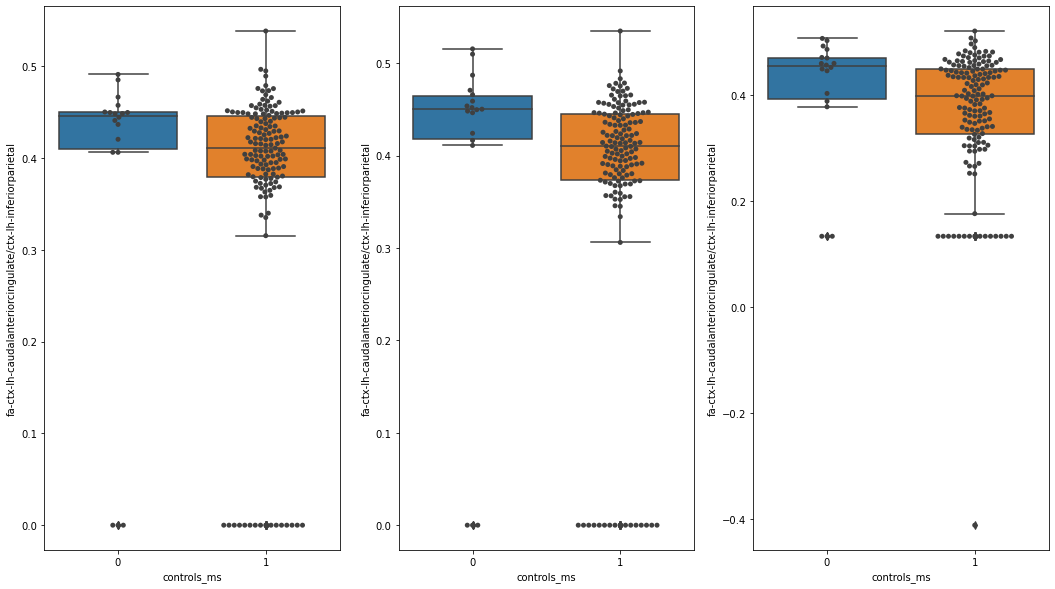

In [5]:
data = [pd.concat([fa_conec, clinical_data], join="inner", axis=1), fa_correct, fa_har]

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for i in range(3):
    sns.boxplot(ax=axes[i],
                y=fa_conec.columns[1], 
                x='controls_ms', 
                data=data[i])

    sns.swarmplot(ax = axes[i],
                  y=fa_conec.columns[1], 
                  x='controls_ms', 
                  data=data[i], 
                  color=".25")

### *3.2. Imputation*

In [3]:
def outlier_imputation(neuro_data):
    """
    Deals with the problem of zero-values in data by using linear regression models for imputation.

    Arguments:
    ----------

    neuro_data: data that have to be corrected. Important, do not include Clinical Data.

    Returns:
    --------

    pandas dataframe with the corrected data.
    """
    columns = [col for col in neuro_data.columns]
    df = neuro_data.copy()
    
    model = LinearRegression()

    for col in columns:
        if df[df[col] == 0].shape[0] != 0:
            X_train, y_train = df[df[col] != 0].drop([col], axis = 1), df[df[col] != 0][col]
            X_test = df[df[col] == 0].drop([col], axis = 1)

            model = LinearRegression()
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            df.loc[X_test.index, col] = pred
    return df

In [7]:
# Clinical Data

clinical_data = fa.iloc[:, -5:]

# Connectivity test
index = connectivity_test(fa.iloc[:, :-5], clinical_data)

fa_conec = fa.iloc[:, index]

# age and sex corrections
fa_correct = linear_correction(clinical_data, fa_conec)
fa_imputed = outlier_imputation(fa_correct.iloc[:, :-5])

# harmonization
fa_har = harmonization(fa_imputed, clinical_data)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


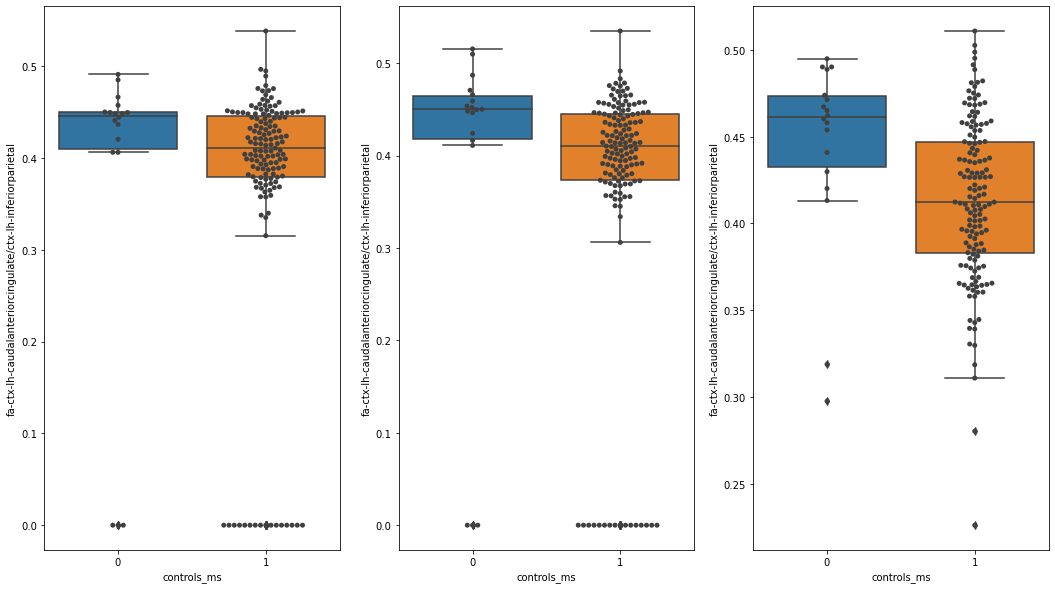

In [8]:
data = [pd.concat([fa_conec, clinical_data], join="inner", axis=1), fa_correct, fa_har]

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for i in range(3):
    sns.boxplot(ax=axes[i],
                y=fa_conec.columns[1], 
                x='controls_ms', 
                data=data[i])

    sns.swarmplot(ax = axes[i],
                  y=fa_conec.columns[1], 
                  x='controls_ms', 
                  data=data[i], 
                  color=".25")

### 3.3. Statistical Significance

In [4]:
# Kamila

def stats_data(data):
    patients_fa = data.loc[data["controls_ms"] == 1].copy()
    patients_fa.drop(labels = ["controls_ms", "age", "sex", "dd", "edss"], axis = 1, inplace = True)
    controls_fa = data.loc[data["controls_ms"] == 0].copy()
    controls_fa.drop(labels =  ["controls_ms", "age", "sex", "dd", "edss"], axis = 1, inplace = True)
    feats = data.iloc[:, :-5].columns.to_list()

    return patients_fa, controls_fa, feats

def MW_U(data):
    patients_fa, controls_fa, feats = stats_data(data)
    MannWhitney_tests = pd.DataFrame(columns=['ROI', 'U', 'pvalue'])
    for attr in feats:
        stat,p = mannwhitneyu(patients_fa[attr], controls_fa[attr])
        MannWhitney_tests = MannWhitney_tests.append({'ROI': attr, 'U': stat, 'pvalue': p}, ignore_index=True)

    test, p_corr = fdrcorrection(MannWhitney_tests["pvalue"], alpha = 0.05, method = "indep", is_sorted = False)
    MannWhitney_tests ["Rejected"] = test
    MannWhitney_tests ["p_corr"] = p_corr

    return MannWhitney_tests

def statistically_significant_variables(data, tolerance, name):
    MW = MW_U(data)
    difference_fa = MW[MW["p_corr"] < tolerance]
    if len(difference_fa) <= 5:
        print("No Significant Variables in", name)
        return 0

    different_fa = difference_fa["ROI"].tolist()
    fa_har_clinical = data.loc[:,["age", "sex", "dd", "edss", "controls_ms"]]
    fa_har_t = data[different_fa]
    fa_har_new = pd.merge(fa_har_t, fa_har_clinical, left_index=True, right_index=True)

    return fa_har_new

# Eloy 

def types_diff(data):
    conn_stat = pd.DataFrame(columns=['ROI','pvalue'])
    feats = data.iloc[:, :-1].columns.to_list()
    for connections in feats:
        stat,p = shapiro(data[connections])
        alpha=0.05
        sample1 = data.loc[data["controls_ms"]==0,connections]
        sample2 = data.loc[data["controls_ms"]==1,connections]
        if p > alpha:
            stat, p = bartlett(sample1,sample2)
            homovar = True
            if (p<=0.05):
                homovar = False
            stat,p = ttest_ind(sample1,sample2,equal_var=homovar)
        else:
            stat,p = mannwhitneyu(data.loc[data["controls_ms"]==0,connections],data.loc[data["controls_ms"]==1,connections],alternative='two-sided')
    
        if (p<=0.05):
            conn_stat = conn_stat.append({'ROI': connections,'pvalue': p}, ignore_index=True)
        
    print('Statistically diferences in %d of connections' % len(conn_stat))

    diff = conn_stat.copy()

    p_corr = multipletests(diff["pvalue"], alpha = 0.05, method = "bonferroni", is_sorted = False)
    diff["p_corr"] = p_corr[1] #Added the bonferroni correction
    diff_fdr = diff[diff["p_corr"] < 0.05] #FDR correction with lowest pvalue
    print('Statistically diferences in %d of connections with FDR' % len(diff_fdr))
    diff_fa = diff_fdr["ROI"].tolist()
    fa_clinic = data.loc[:,["age", "sex", "dd", "edss", "controls_ms"]]
    #Adding index fa_har
    # fa_har = data.set_index(data.index) perque???
    fa_har_bonferroni = data[diff_fa]
    fa_har_corr = pd.merge(fa_har_bonferroni, fa_clinic, left_index=True, right_index=True)
    
    return fa_har_corr


# fa_har_0 = statistically_significant_variables(fa_har, 0.05, "FA Harmonizated Data")
# fa_har_1 = types_diff(fa_har)

### 3.4. Proprocessing Pipelines (*Not the final ones*)

In [24]:
def wm_pipeline(neuro_data, clinical_data, index, tolerance, name, mw=True):

    wm_conec = neuro_data.iloc[:, index]

    # age and sex corrections
    wm_correct = linear_correction(clinical_data, wm_conec)
    wm_imputed = outlier_imputation(wm_correct.iloc[:, :-5])

    # harmonization
    wm_har = harmonization(wm_imputed, clinical_data)

    # Statistical Significance

    if mw:
        # wm_final = statistically_significant_variables(wm_har, tolerance, name)
        wm_final = types_diff(wm_har)
        return wm_final

    return wm_har

def gm_pipeline(neuro_data, clinical_data, index, tolerance, name, mw=True):

    gm_conec = neuro_data.iloc[:, index]

    # age and sex corrections
    gm_correct = linear_correction(clinical_data, gm_conec)
    gm_imputed = outlier_imputation(gm_correct.iloc[:, :-5])
    gm_imputed = pd.concat([gm_imputed, gm.iloc[:, -5:]], axis=1, join="inner")

    # Statistical Significance

    if mw:
        # gm_final = statistically_significant_variables(gm_imputed, tolerance, name)
        gm_final = types_diff(gm_imputed)
        return gm_final

    return gm_imputed

## ***4. controls_ms***

### *4.1. Data Preparation*

In [25]:
# Significant variables from the connectivity test

index = connectivity_test(fa.iloc[:, :-5], fa.iloc[:, -5:])

# Processing Data

fa_controls = wm_pipeline(fa.iloc[:, :-5], fa.iloc[:, -5:], index, 0.05, "FA Data")
gm_controls = gm_pipeline(gm.iloc[:, :-5], gm.iloc[:, -5:], index, 0.05, "GM Networks Data")
func_controls = gm_pipeline(func.iloc[:, :-5], func.iloc[:, -5:], index, 0.05, "Functional Data")

# Join GM data and processing it

gm_final = pd.DataFrame((np.array(gm.iloc[:, :-5]) + np.array(func.iloc[:, :-5])), columns=gm.iloc[:, :-5].columns, index=gm.index)
gm_final = gm_pipeline(gm_final, gm.iloc[:, -5:], index, 0.05, "GM Combined Data")

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Statistically diferences in 1132 of connections
Statistically diferences in 185 of connections with FDR
Statistically diferences in 381 of connections
Statistically diferences in 6 of connections with FDR
Statistically diferences in 130 of connections
Statistically diferences in 4 of connections with FDR
Statistically diferences in 150 of connections
Statistically diferences in 4 of connections with FDR


### *4.2. Evaluation Metric: Logistic Regression*

Before going through different dimensionality reduction techniques, it's important to establish a general metric to have a starting point on which to base ourselves when evaluating the effectiveness of the applied techniques.

First of all, let's switch the target (*controls_ms*) for bla bla bla

In [39]:
controls_list = [0 if num == 1 else 1 for num in fa_har.iloc[:, -1]]
fa_controls.iloc[:, -1] = controls_list

fa_controls.iloc[:, -1].describe()

count    165.000000
mean       0.109091
std        0.312702
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: controls_ms, dtype: float64

In [47]:
def evaluation(X, y):
    mean_score = 0
    logistic_model = LogisticRegression()
    kf = StratifiedKFold(n_splits=5)
    sc = StandardScaler()
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = sc.fit_transform(X.iloc[train_index, :]), y.iloc[train_index]
        X_test, y_test = sc.transform(X.iloc[test_index, :]), y.iloc[test_index]
        logistic_model.fit(X_train, y_train)
        y_hat = logistic_model.predict(X_test)
        mean_score += f1_score(y_hat, y_test)
    print(mean_score/5)

X = fa_controls.iloc[:, :-8]
y = fa_controls.iloc[:, -1]

evaluation(X, y)

0.3514285714285714


### **4.3. FA Data**

**4.3.1. PCA Feature Extraction**

Text(0, 0.5, 'Cumulative Variability')

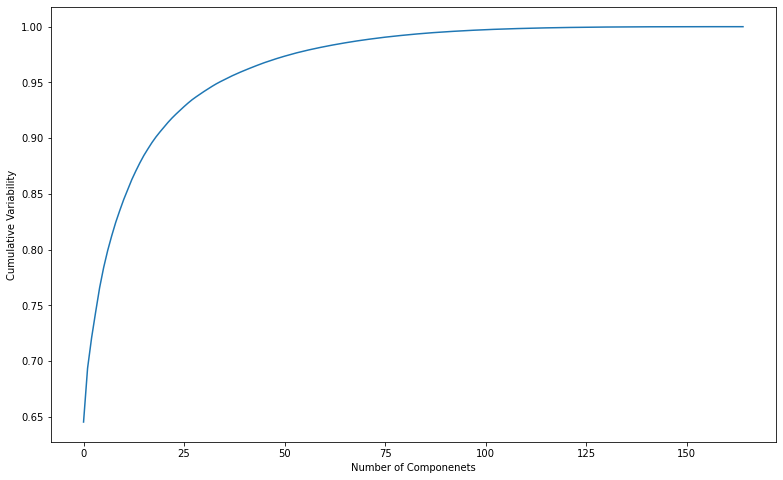

In [49]:
pca = PCA().fit(X)

plt.figure(figsize=(13, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Componenets")
plt.ylabel("Cumulative Variability")

In [50]:
pca = PCA(n_components=0.95)
fa_pca = pca.fit_transform(X)

column_names = ["PCA " + str(i) for i in range(fa_pca.shape[1])]
fa_pca = pd.DataFrame(fa_pca, columns = column_names, index = fa.index)
fa_pca

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,...,PCA 25,PCA 26,PCA 27,PCA 28,PCA 29,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34
002MSVIS,0.189727,-0.282577,0.141441,0.029868,0.099128,-0.006183,-0.072685,-0.020088,-0.030385,0.091222,...,-0.035544,-0.030892,-0.011145,0.017992,-0.027740,-0.020332,0.011541,-0.031501,0.021026,-0.017960
003MSVIS,0.366812,0.189120,0.134929,-0.020360,-0.078335,-0.050039,0.017226,0.059881,-0.089621,-0.035426,...,-0.037009,-0.011546,0.039937,-0.024237,-0.005702,-0.009861,0.004968,0.049995,-0.015243,0.020570
004MSVIS,-0.303292,0.099025,0.033586,-0.045441,-0.030555,-0.041340,-0.068414,0.058032,-0.119711,0.041612,...,0.035925,0.003382,0.006948,0.005103,0.003667,0.030142,-0.005218,0.042272,0.028634,-0.015866
005MSVIS,-0.163285,-0.061129,0.063816,-0.077220,-0.006111,-0.064887,0.050995,-0.031220,-0.040411,-0.022895,...,-0.040101,-0.016450,-0.040725,0.037196,0.056287,-0.031094,-0.030488,-0.024595,-0.024204,-0.026139
010MSVIS,0.330190,0.149399,-0.076030,-0.032494,0.101767,0.082829,0.012613,-0.044364,-0.050956,-0.022462,...,-0.010697,-0.008441,0.005265,-0.032153,0.003215,0.002656,-0.014955,-0.012919,-0.008384,-0.020122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,-0.414536,-0.060128,0.076479,0.038304,-0.035214,-0.055503,0.028699,-0.016791,0.036213,-0.038383,...,-0.035115,-0.042370,-0.038565,0.013287,-0.018503,0.007858,0.005781,0.007659,-0.039752,0.001343
sFIS_05,-0.494368,0.022498,-0.015155,0.069850,-0.032470,0.028675,-0.039171,-0.024391,0.032110,-0.075008,...,-0.032499,-0.012841,0.020828,0.009989,-0.028382,-0.006847,0.072036,0.013038,0.030814,-0.000309
sFIS_06,-0.737085,-0.066424,-0.095284,0.070069,-0.019384,0.015124,0.043656,-0.107753,0.006336,-0.025181,...,-0.011805,0.035109,-0.017654,0.012414,-0.000322,-0.018212,0.013256,-0.056902,-0.020506,-0.022056
sFIS_07,-0.284230,-0.019977,-0.036610,0.023739,-0.037136,0.026254,0.005139,-0.079040,0.010733,0.041578,...,-0.043295,-0.040412,0.015190,0.022695,-0.026058,-0.008522,0.005291,-0.006364,0.028452,0.005179


In [51]:
variable_list = list()

num = pca.explained_variance_ratio_.sum()/100

for i in range(len(pca.components_)):
    aux = int(pca.explained_variance_ratio_[i] / num)
    if aux == 0:
        aux = 1
    test_df = pd.DataFrame(abs(pca.components_)[i])
    aux_list = test_df[0].sort_values(ascending=False).index[:aux]
    variable_list.append([num for num in aux_list])

final_list = list()
for i in range(len(variable_list)): # Només n'he possat 1
    for j in range(len(variable_list[i])):
        if variable_list[i][j] not in final_list:
            final_list.append(variable_list[i][j])

pca_columns = [name for name in X.iloc[:, final_list].columns]
pca_df = fa.iloc[:, final_list[:25]]

In [62]:
evaluation(X.iloc[:, final_list[:30]], y)

0.31714285714285717


**4.3.2. Feature Importance with Random Forest**

The feature importance in random forest is computed by using the *gini importance*

**Gini importance** (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance. This method is available in scikit-learn implementation of the Random Forest (for both classifier and regressor). It is worth to mention, that in this method we should look at relative values of the computed importances. This biggest advantage of this method is a speed of computation - all needed values are computed during the Radom Forest training. The drawbacks of the method is to tendency to prefer (select as important) numerical features and categorical features with high cardinality. **What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).**

In [63]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(X, y)

RandomForestClassifier(max_depth=2, n_estimators=1000)

[Text(0.5, 1.0, 'Sorted Feature Importance'),
 Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance')]

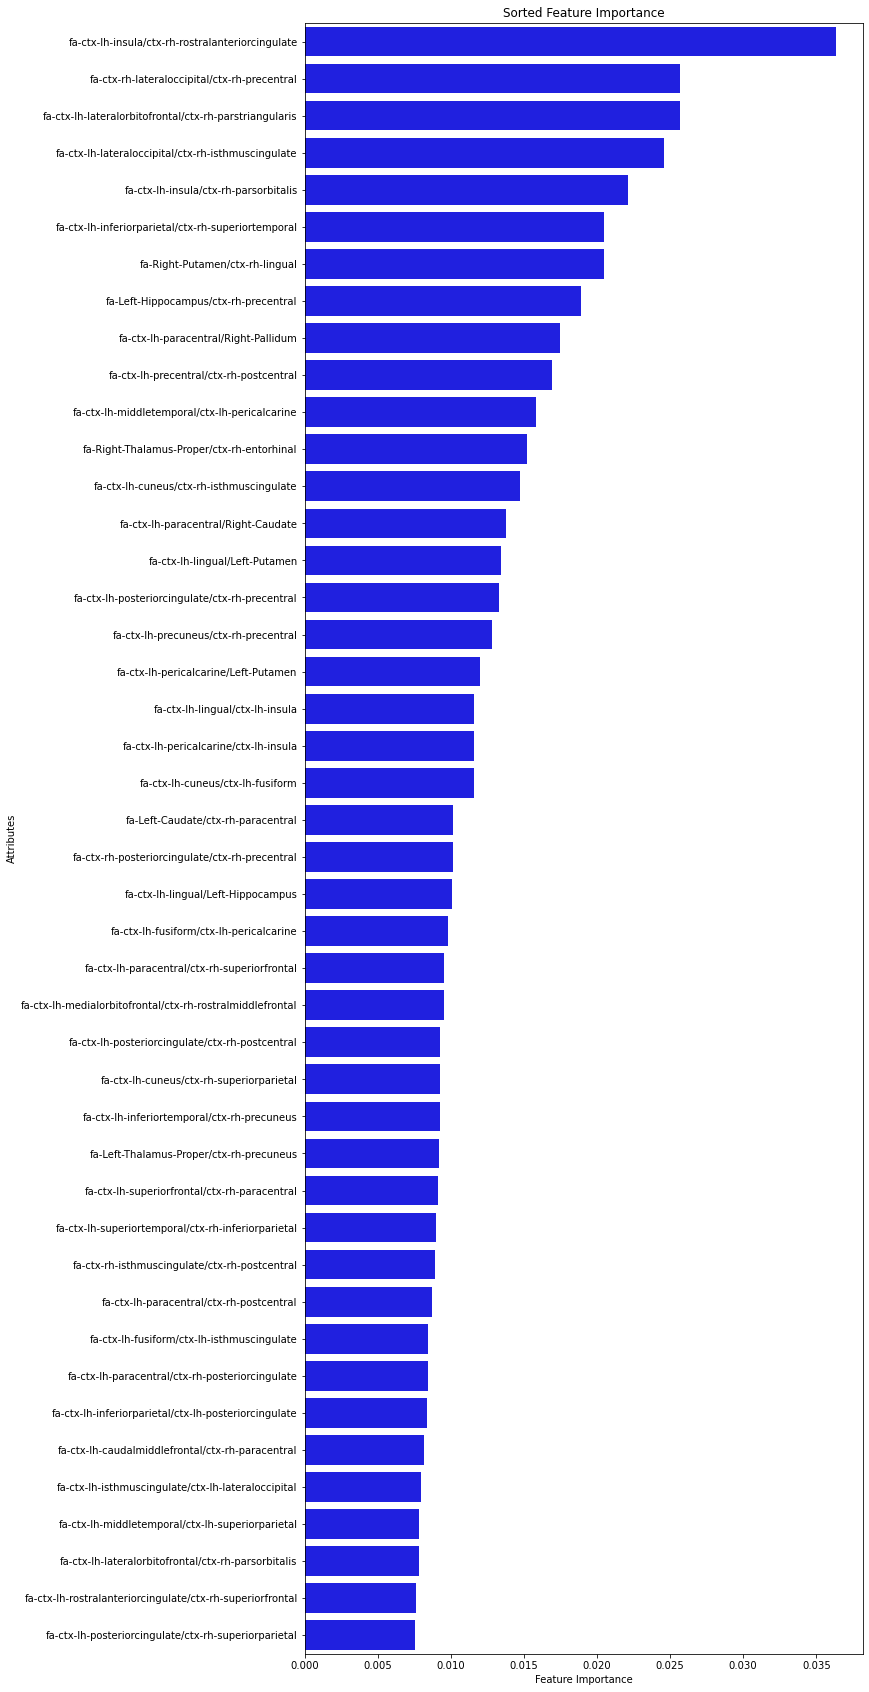

In [64]:
# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

Once we have selected the first fifty most important features, let's evaluate the efectivity of the model using them.

In [84]:
rf_columns = [col for col in importance_sorted.index]

evaluation(X.loc[:, rf_columns[:4]], y) # 27 is optimal but with 3 we obtain 50% 

0.6433333333333333


In [85]:
rf_columns[0:5]

['fa-ctx-lh-insula/ctx-rh-rostralanteriorcingulate',
 'fa-ctx-rh-lateraloccipital/ctx-rh-precentral',
 'fa-ctx-lh-lateralorbitofrontal/ctx-rh-parstriangularis',
 'fa-ctx-lh-lateraloccipital/ctx-rh-isthmuscingulate',
 'fa-ctx-lh-insula/ctx-rh-parsorbitalis']

Finally, let's visualizate the first nine features in terms of feature importance.

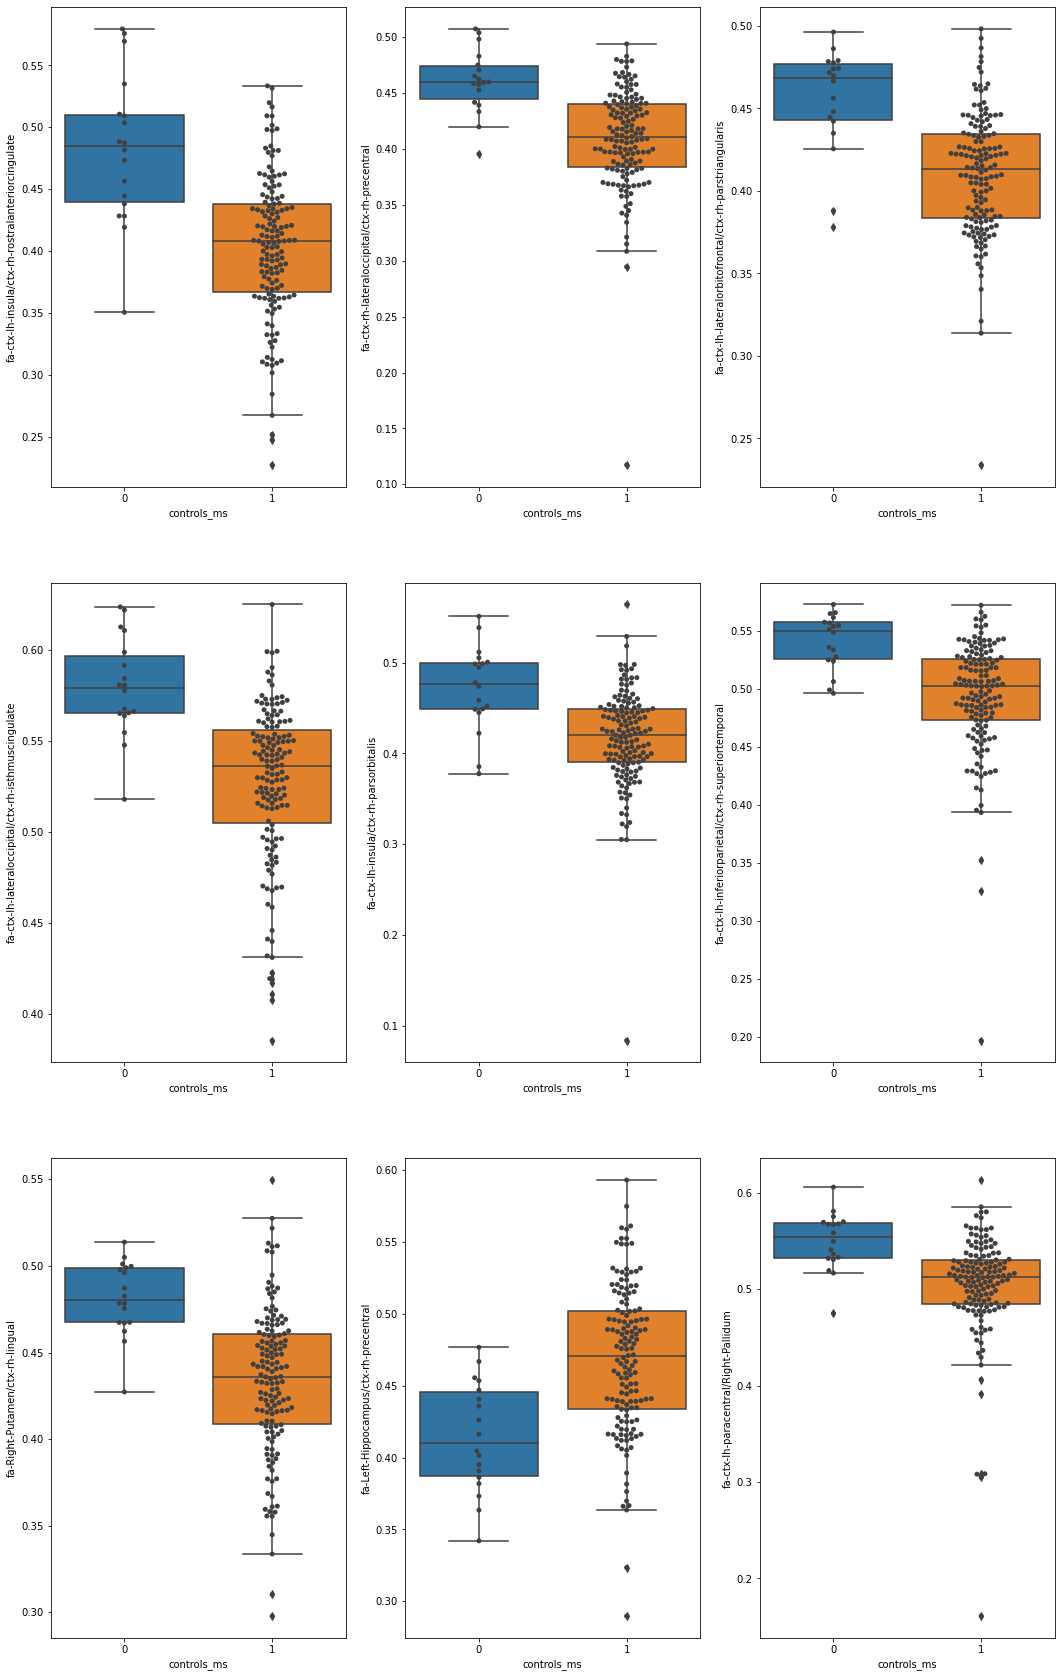

In [86]:
ploting = pd.concat([X, fa.iloc[:, -1]], axis=1, join="inner")

fig, axes = plt.subplots(3, 3, figsize=(18, 30))

for i in range(3):
    for j in range(3):
        sns.boxplot(ax=axes[i, j],
                    y=rf_columns[(i*3)+j], 
                    x='controls_ms', 
                    data=ploting)

        sns.swarmplot(ax = axes[i, j],
                     y=rf_columns[(i*3)+j], 
                     x='controls_ms', 
                     data=ploting, 
                     color=".25")

**4.3.3. Clustering**

In [90]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=30, random_state=42)),
    ("log", LogisticRegression(max_iter=1000)),
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=30, random_state=42)),
                ('log', LogisticRegression(max_iter=1000))])

In [91]:
pred = pipeline.predict(X_valid)

In [92]:
f1_score(pred, y_valid)

0.0

## 5. *edss*

### *5.1. Data Preparation*

In [93]:
fa_edss = fa.loc[fa["controls_ms"] == 1]
gm_edss = gm.loc[gm["controls_ms"] == 1]
func_edss = func.loc[func["controls_ms"] == 1]
gm_final = pd.DataFrame((np.array(gm_edss.iloc[:, :-5]) + np.array(func_edss.iloc[:, :-5])), columns=gm_edss.iloc[:, :-5].columns, index=gm_edss.index)

fa_edss = wm_pipeline(fa_edss.iloc[:, :-5], fa_edss.iloc[:, -5:], index, 0.05, "FA Data", False)
gm_edss = gm_pipeline(gm_edss.iloc[:, :-5], gm_edss.iloc[:, -5:], index, 0.05, "GM Networks Data", False)
func_edss = gm_pipeline(func_edss.iloc[:, :-5], func_edss.iloc[:, -5:], index, 0.05, "Functional Data", False)

gm_final = gm_pipeline(gm_final, gm_edss.iloc[:, -5:], index, 0.05, "GM Combined Data", False)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


### *5.1. Evaluation Metric: Linear Regression*

In [94]:
def evaluation_linear(X, y):
    mean_score = 0
    logistic_model = LinearRegression()
    kf = KFold(n_splits=5)
    sc = StandardScaler()
    for train_index, test_index in kf.split(X):
        X_train, y_train = sc.fit_transform(X.iloc[train_index, :]), y.iloc[train_index]
        X_test, y_test = sc.transform(X.iloc[test_index, :]), y.iloc[test_index]
        logistic_model.fit(X_train, y_train)
        y_hat = logistic_model.predict(X_test)
        mean_score += mean_squared_error(y_hat, y_test, squared=False)
    print(mean_score/5)

### 5.2. FA Data

In [95]:
X = fa_edss.iloc[:, :-5]
y = fa_edss.iloc[:, -2]

evaluation_linear(X, y)

2.3689393131010608


**5.2.1. Random Forest**

In [96]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=2)
rf.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=1000)

[Text(0.5, 1.0, 'Sorted Feature Importance'),
 Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance')]

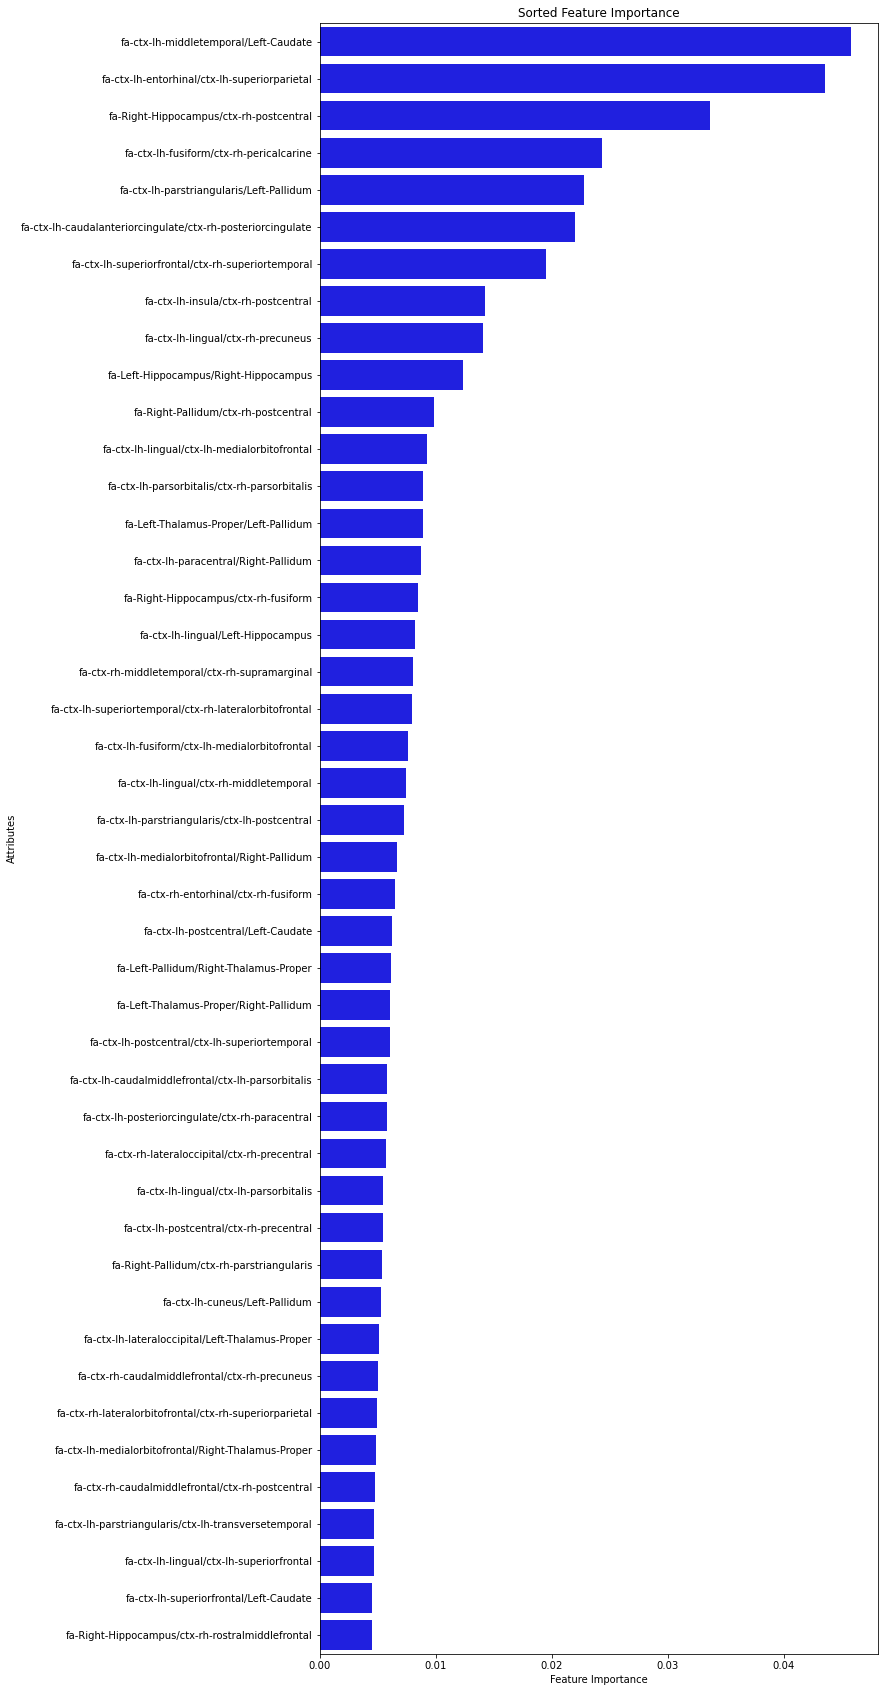

In [97]:
# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [98]:
fa_columns = [col for col in importance_sorted.index]

evaluation_linear(X.loc[:, fa_columns[:5]], y) # 27 is optimal but with 3 we obtain 50% 

1.7071027336691114


### 5.3. GM Data

In [180]:
X = gm_edss.iloc[:, :-5]
y = gm_edss.iloc[:, -2]

evaluation_linear(X, y)

2.253376953626745


**5.3.1. Random Forest**

In [174]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=2)
rf.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=1000)

[Text(0.5, 1.0, 'Sorted Feature Importance'),
 Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance')]

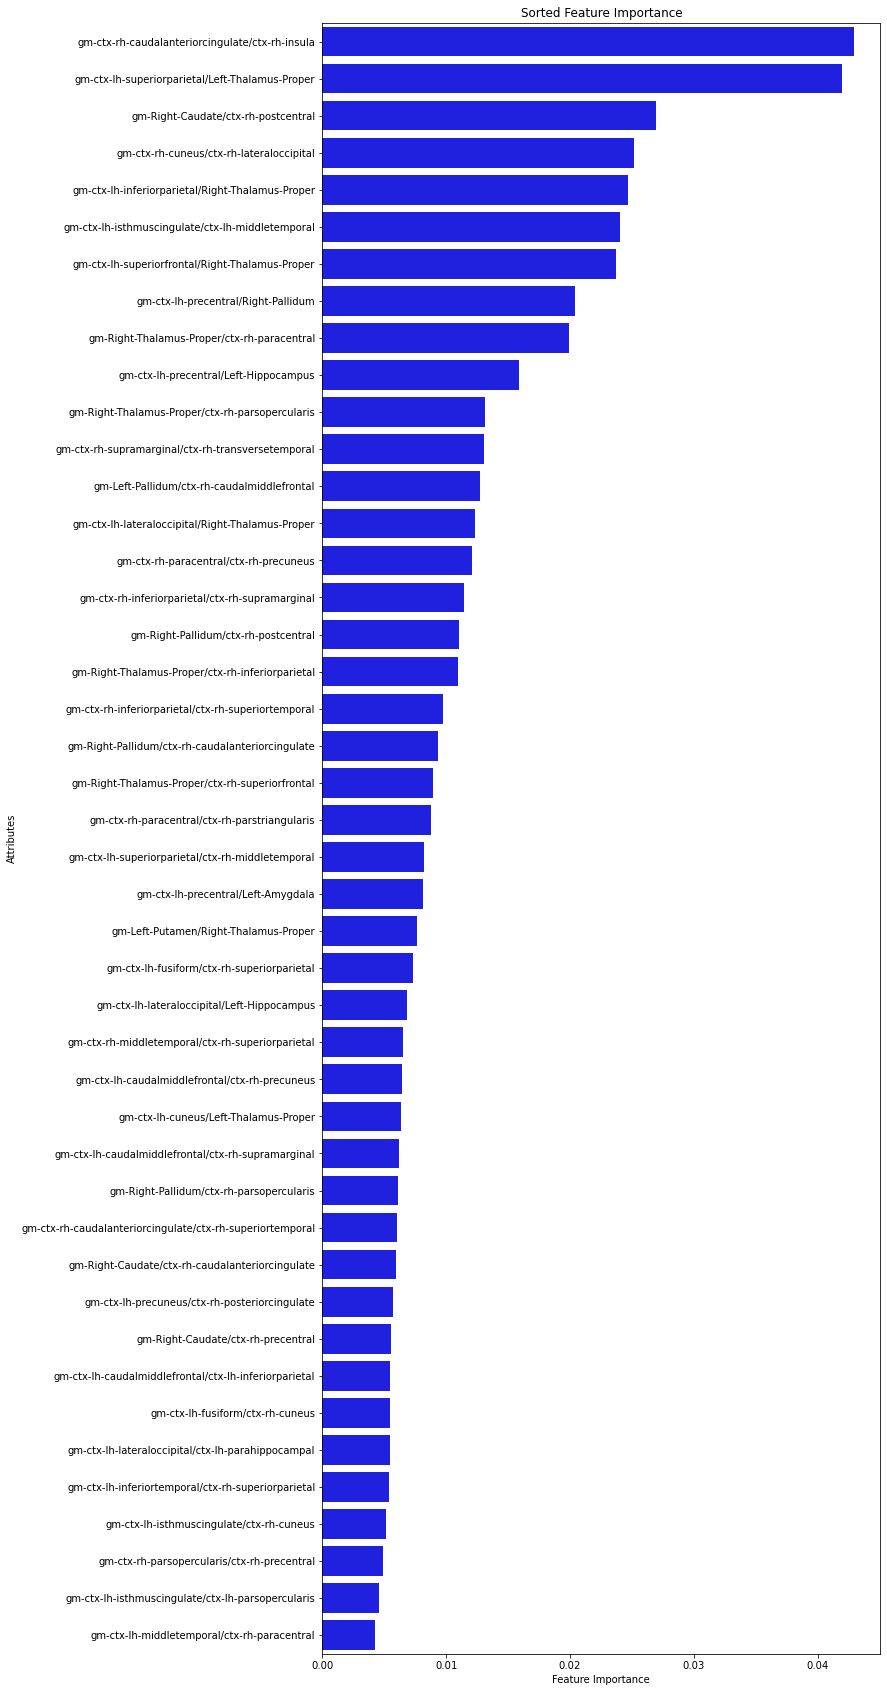

In [175]:
# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [187]:
gm_columns = [col for col in importance_sorted.index]

evaluation_linear(X.loc[:, gm_columns[:5]], y) # 27 is optimal but with 3 we obtain 50% 

1.7832142052792541


### 5.4. Func Data

In [188]:
X = func_edss.iloc[:, :-5]
y = func_edss.iloc[:, -2]

evaluation_linear(X, y)

3.5918434682136953


**5.4.1. Random Forest**

In [178]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=2)
rf.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=1000)

[Text(0.5, 1.0, 'Sorted Feature Importance'),
 Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance')]

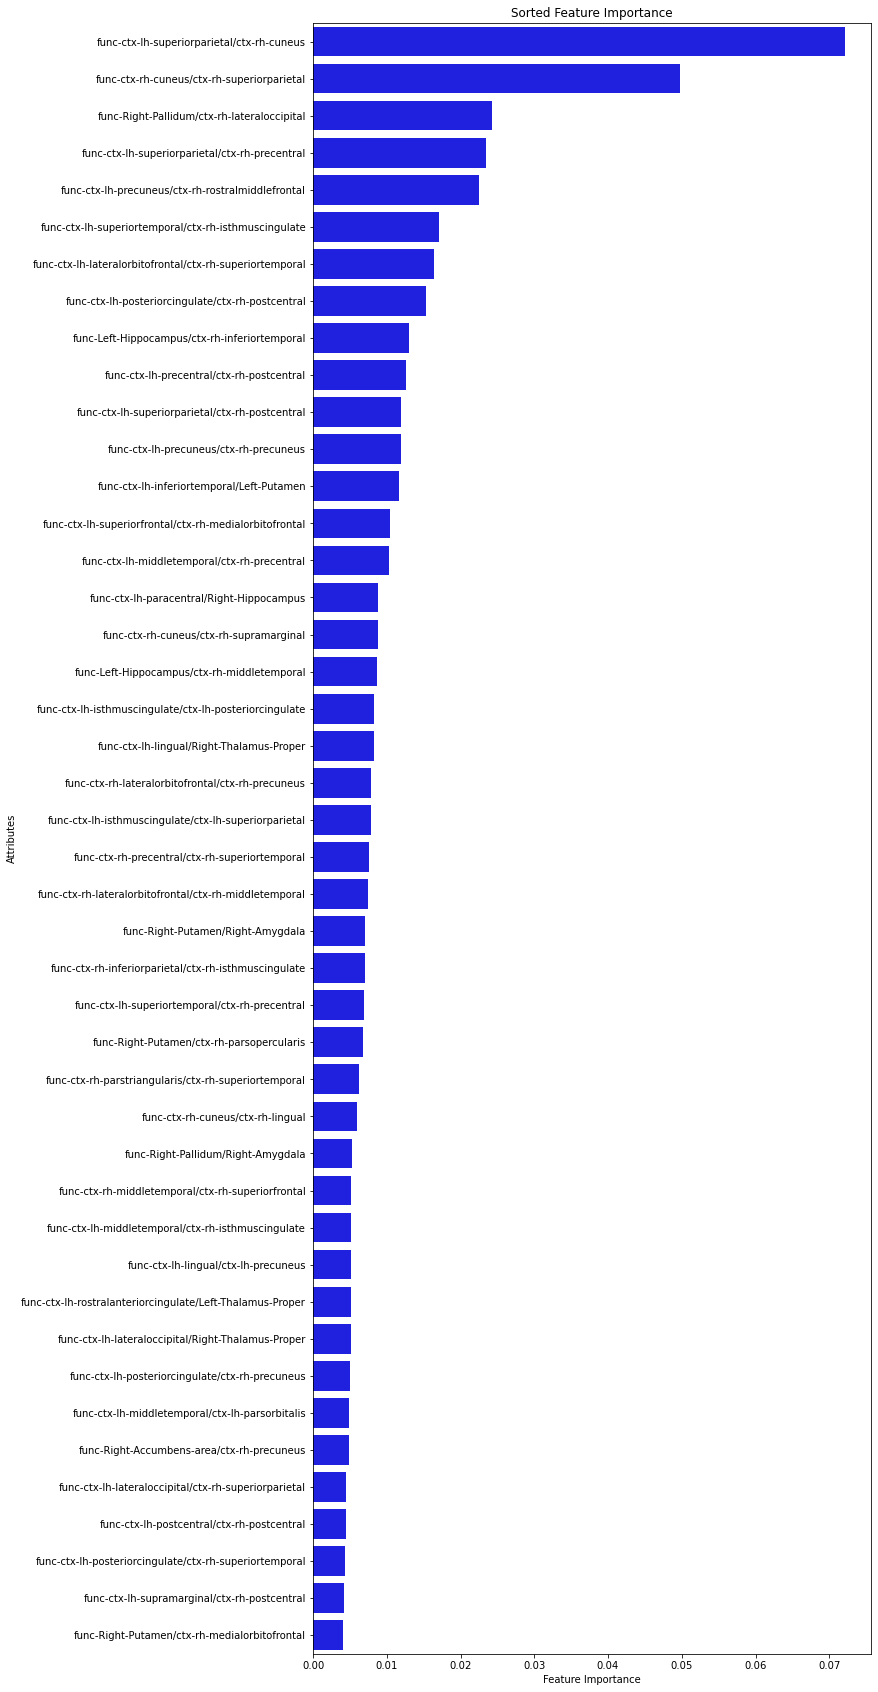

In [189]:
# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [199]:
func_columns = [col for col in importance_sorted.index]

evaluation_linear(X.loc[:, func_columns[:1]], y) # 27 is optimal but with 3 we obtain 50% 

1.6890678027819805


## 6. *dd*

### 6.1. *FA Data*

In [99]:
X = fa_edss.iloc[:, :-5]
y = fa_edss.iloc[:, -3]

evaluation_linear(X, y)

14.503967848142853


In [100]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=2)
rf.fit(X, y)

RandomForestRegressor(max_depth=2, n_estimators=1000)

[Text(0.5, 1.0, 'Sorted Feature Importance'),
 Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance')]

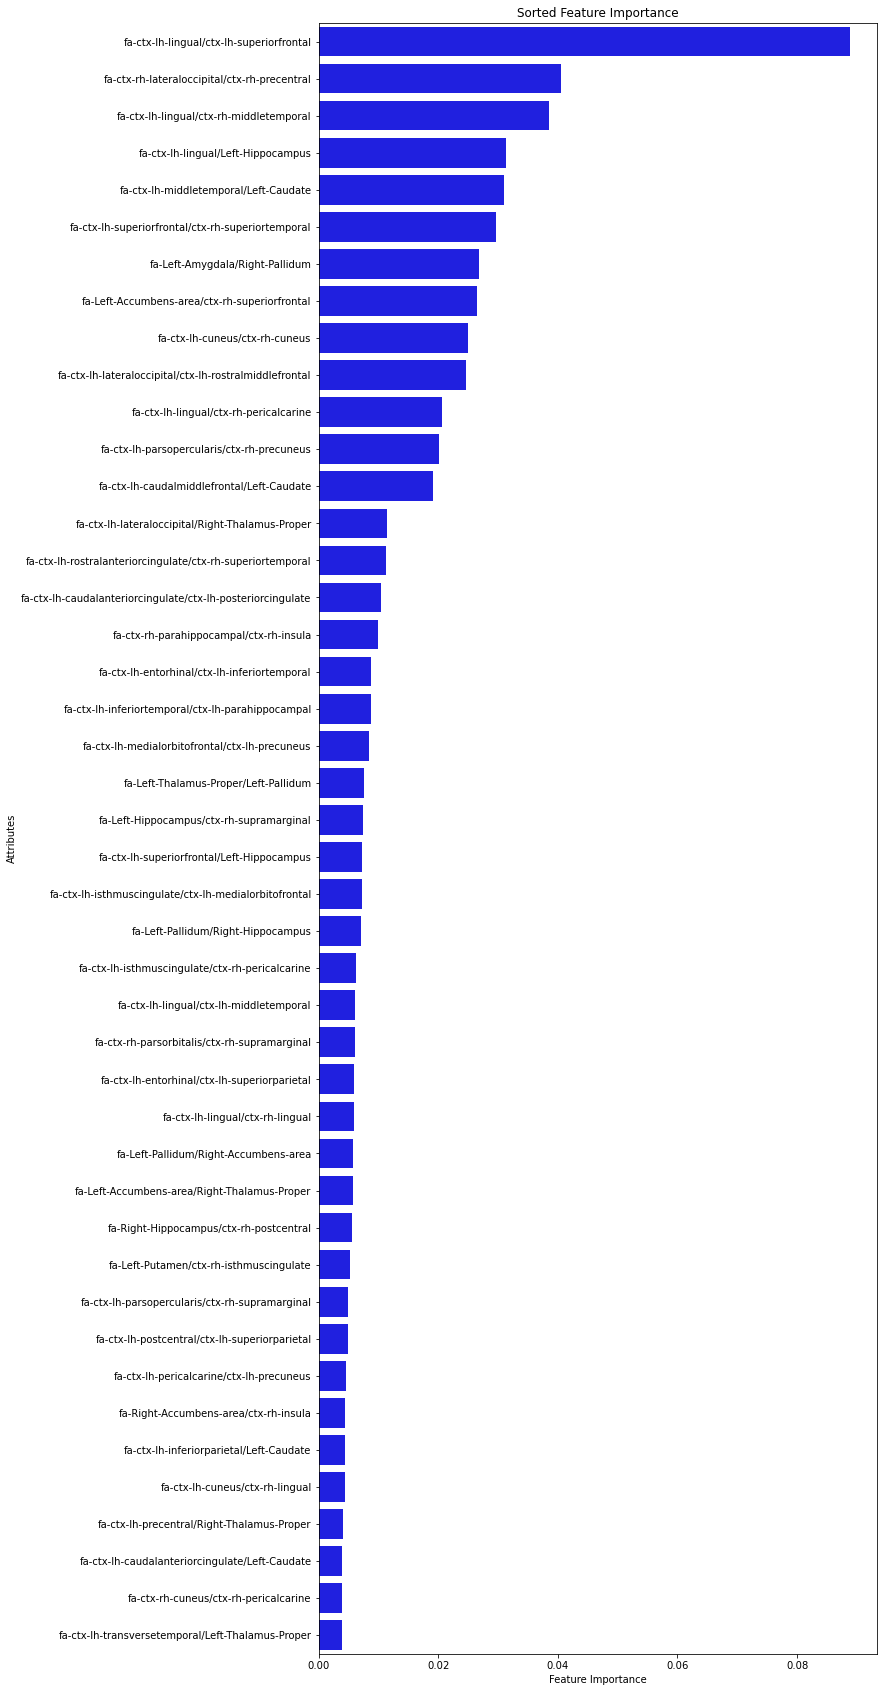

In [101]:
# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [102]:
fa_columns = [col for col in importance_sorted.index]

evaluation_linear(X.loc[:, fa_columns[:3]], y) # 27 is optimal but with 3 we obtain 50% 

8.895259895194258


### 6.2. *GM Data*

In [103]:
X = gm_edss.iloc[:, :-5]
y = gm_edss.iloc[:, -3]

evaluation_linear(X, y)

rf = RandomForestRegressor(n_estimators=1000, max_depth=2)
rf.fit(X, y)

f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

gm_columns = [col for col in importance_sorted.index]

evaluation_linear(X.loc[:, gm_columns[:2]], y) # 27 is optimal but with 3 we obtain 50% 

12.054112904319023
9.326920377513918


### 6.3. *Func Data*

In [104]:
X = func_edss.iloc[:, :-5]
y = func_edss.iloc[:, -3]

evaluation_linear(X, y)

rf = RandomForestRegressor(n_estimators=1000, max_depth=2)
rf.fit(X, y)

f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(X.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:100] # Number of pca features

func_columns = [col for col in importance_sorted.index]

evaluation_linear(X.loc[:, func_columns[:2]], y) # 27 is optimal but with 3 we obtain 50% 

21.472219746431524
9.223075279109665


## 7. Data Augmentation: SMOTE  

In [6]:
def data_augmentation(X, y):

    sm = SMOTE(random_state=42)
    X_res, Y_res = sm.fit_resample(X, y)

    df_smote_over = pd.concat([pd.DataFrame(X_res), pd.DataFrame(Y_res)], axis=1, join="inner")

    return df_smote_over

## 8. Proposed methodology

In [5]:
def classifier_pipeline(fa, gm, func):
    """
    This function is in charge of executing the entire data post-processing process.
    All functions in this scripts are ran in this pipeline, from running the
    connectivity test to data augmentation.

    Arguments:
    ---------

    fa: Fractional Anisotropy Data, containing FA-weighted connectivity matrix with information related to White Matter (WM).

    gm: Structural Gray Matter Brain Network Data, GM connectivity network 

    func: Resting State fMRI Data, containing data from brain signal correlation/synchronization through resting-state functional connectivity

    Returns:
    --------

    X: Pandas data frame containing the most statistically significant variables in order to describe the behavior of the target. 
    This data frame has been corrected from biases such as sex, age, and "scanner effects". A data augmentation process has also 
    been applied to deal with the imbalance of the target, which contains few Health Subjects.

    y: Target (controls_ms)
    """

    index = connectivity_test(fa.iloc[:, :-5], fa.iloc[:, -5:])

    X_fa, y = wm_pipeline(fa.iloc[:, :-5], fa.iloc[:, -5:], index)
    X_gm, y = gm_pipeline(gm.iloc[:, :-5], gm.iloc[:, -5:], index)
    X_func, y = gm_pipeline(func.iloc[:, :-5], func.iloc[:, -5:], index)

    X = pd.concat([X_fa, X_gm, X_func], join="inner", axis=1)

    df_final = data_augmentation(X, y)

    return df_final.iloc[:, :-1], df_final.iloc[:, -1]


def wm_pipeline(neuro_data, clinical_data, index):
    """
    All the post-processing data process applied to White Matter matrices are contained
    in this pipeline (age and gender correction, harmonization, feature selection, and
    data augmentation)

    Arguments:
    ---------

    neuro_data: Fractional Anisotropy Data, containing FA-weighted connectivity matrix with information related to White Matter (WM).

    clinical_data: self-explanatory.

    index: list containing all the names from the features that successfully passed the connectivity test.

    Returns:
    --------

    wm_final.iloc[:, :-1]: Pandas dataframe with the post-processed features
    
    wm_final.iloc[:, -1]: Pandas dataframe with the target variable.
    """

    wm_conec = neuro_data.iloc[:, index]

    # age and sex corrections
    wm_correct = linear_correction(clinical_data, wm_conec)
    wm_imputed = outlier_imputation(wm_correct.iloc[:, :-5])

    # harmonization
    wm_har = harmonization(wm_imputed, clinical_data)

    # Statistical Significance

    # wm_final = statistically_significant_variables(wm_har, tolerance, name)
    wm_final = types_diff(wm_har)

    return wm_final.iloc[:, :-8], wm_final.iloc[:, -1]


def gm_pipeline(neuro_data, clinical_data, index):
    """
    All the post-processing data process applied to Gray Matter matrices are contained
    in this pipeline (age and gender correction, feature selection, and data augmentation)

    Arguments:
    ---------

    neuro_data: Structural Gray Matter Brain Network Data or Resting State fMRI Data.

    clinical_data: self-explanatory.

    index: list containing all the names from the features that successfully passed the connectivity test.

    Returns:
    --------

    gm_final.iloc[:, :-1]: Pandas dataframe with the post-processed features
    
    gm_final.iloc[:, -1]: Pandas dataframe with the target variable.
    """

    gm_conec = neuro_data.iloc[:, index]

    # age and sex corrections
    gm_correct = linear_correction(clinical_data, gm_conec)
    gm_imputed = outlier_imputation(gm_correct.iloc[:, :-5])
    gm_imputed = pd.concat([gm_imputed, clinical_data], axis=1, join="inner")

    # Statistical Significance

    # gm_final = statistically_significant_variables(gm_imputed, tolerance, name)
    gm_final = types_diff(gm_imputed)

    return gm_final.iloc[:, :-8], gm_final.iloc[:, -1]

In [7]:
X, y = classifier_pipeline(fa, gm, func)

NameError: name 'fa' is not defined